In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE


In [5]:
# Load the dataset
df = pd.read_csv("C:\\Users\\hp\\Downloads\\telecom_churn_data.csv")

# Overview of data structure and missing values
print(df.info())
print(df.describe())
print(df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB
None
       mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  \
count   9.999900e+04    99999.0         98981.0         98981.0   
mean    7.001207e+09      109.0             0.0             0.0   
std     6.956694e+05        0.0             0.0             0.0   
min     7.000000e+09      109.0             0.0             0.0   
25%     7.000606e+09      109.0             0.0             0.0   
50%     7.001205e+09      109.0             0.0             0.0   
75%     7.001812e+09      109.0             0.0             0.0   
max     7.002411e+09      109.0             0.0             0.0   

       loc_ic_t2o_mou        arpu_6        arpu_7        arpu_8        arpu_9  \
count         98981.0  99999.000000  99999.000000  99999.000000  99999.000000   
mean              0.0    282.987358

In [6]:
# Drop columns with over 30% missing values
threshold = 0.3 * df.shape[0]
df.dropna(thresh=threshold, axis=1, inplace=True)

# Fill missing values for numeric columns with the median
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

# Fill missing values for non-numeric columns with the mode or a placeholder
non_numeric_cols = df.select_dtypes(exclude=['float64', 'int64']).columns
df[non_numeric_cols] = df[non_numeric_cols].fillna(df[non_numeric_cols].mode().iloc[0])


In [7]:
# Find recharge-related columns for months 6 and 7
print([col for col in df.columns if 'rech' in col.lower() or 'amt' in col.lower()])

# Suppose recharge columns are named 'total_rech_amt_6' and 'total_rech_amt_7'
df['avg_recharge_6_7'] = (df['total_rech_amt_6'] + df['total_rech_amt_7']) / 2

# Define high-value customers (70th percentile threshold)
threshold_value = df['avg_recharge_6_7'].quantile(0.7)
high_value_df = df[df['avg_recharge_6_7'] >= threshold_value]


['total_rech_num_6', 'total_rech_num_7', 'total_rech_num_8', 'total_rech_num_9', 'total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8', 'total_rech_amt_9', 'max_rech_amt_6', 'max_rech_amt_7', 'max_rech_amt_8', 'max_rech_amt_9', 'date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8', 'date_of_last_rech_9', 'last_day_rch_amt_6', 'last_day_rch_amt_7', 'last_day_rch_amt_8', 'last_day_rch_amt_9']


C:\Users\hp\AppData\Local\Temp\ipykernel_23624\2599385045.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['avg_recharge_6_7'] = (df['total_rech_amt_6'] + df['total_rech_amt_7']) / 2


In [12]:
# Create avg_recharge_6_7 column and add it to the main DataFrame using pd.concat
avg_recharge_6_7 = (df['total_rech_amt_6'] + df['total_rech_amt_7']) / 2
df = pd.concat([df, pd.DataFrame({'avg_recharge_6_7': avg_recharge_6_7})], axis=1)


In [ ]:
# Calculate average recharge for months 6 and 7
df['avg_recharge_6_7'] = (df['total_rech_amt_6'] + df['total_rech_amt_7']) / 2

# Define high-value customers (70th percentile threshold)
threshold_value = df['avg_recharge_6_7'].quantile(0.7)
high_value_df = df[df['avg_recharge_6_7'] >= threshold_value].copy()


In [ ]:
# Define churners in high_value_df using .loc
high_value_df.loc[:, 'churn'] = np.where(
    (high_value_df['total_ic_mou_9'] == 0) & 
    (high_value_df['total_og_mou_9'] == 0) & 
    (high_value_df['vol_2g_mb_9'] == 0) & 
    (high_value_df['vol_3g_mb_9'] == 0), 
    1, 0
)


In [ ]:
# Drop month 9 columns after tagging churn
high_value_df = high_value_df.drop([col for col in high_value_df.columns if '_9' in col], axis=1)


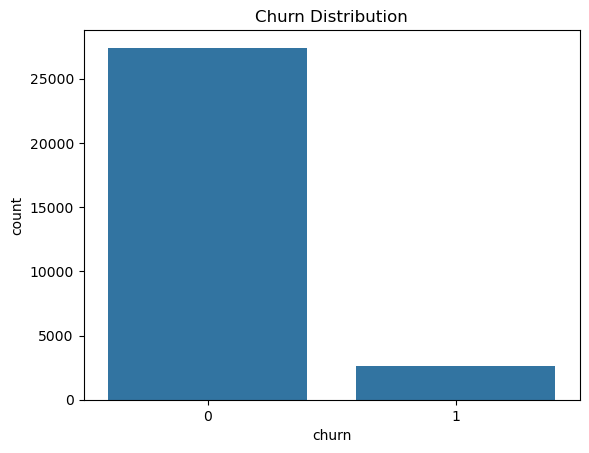

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=high_value_df, x='churn')
plt.title('Churn Distribution')
plt.show()


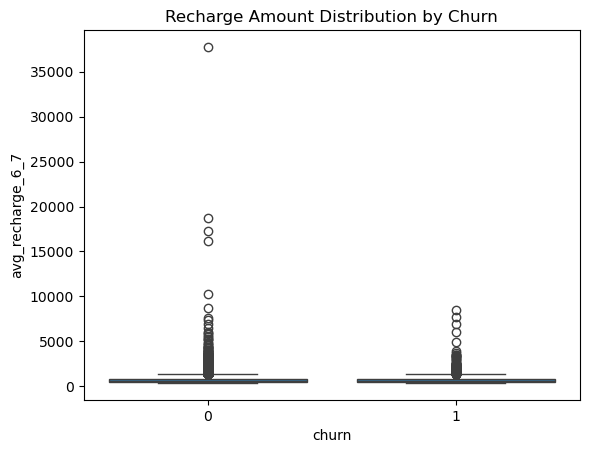

In [15]:
sns.boxplot(data=high_value_df, x='churn', y='avg_recharge_6_7')
plt.title('Recharge Amount Distribution by Churn')
plt.show()


In [22]:
from sklearn.preprocessing import StandardScaler

# Identify purely numerical columns (float and int) for scaling
numerical_cols = high_value_df.select_dtypes(include=['float64', 'int64']).columns

# Scale only these numerical columns
scaler = StandardScaler()
high_value_df[numerical_cols] = scaler.fit_transform(high_value_df[numerical_cols])


In [23]:
print(numerical_cols)


Index(['mobile_number', 'circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou',
       'loc_ic_t2o_mou', 'arpu_6', 'arpu_7', 'arpu_8', 'onnet_mou_6',
       'onnet_mou_7',
       ...
       'monthly_3g_8', 'sachet_3g_6', 'sachet_3g_7', 'sachet_3g_8', 'aon',
       'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g', 'sep_vbc_3g',
       'avg_recharge_6_7'],
      dtype='object', length=137)


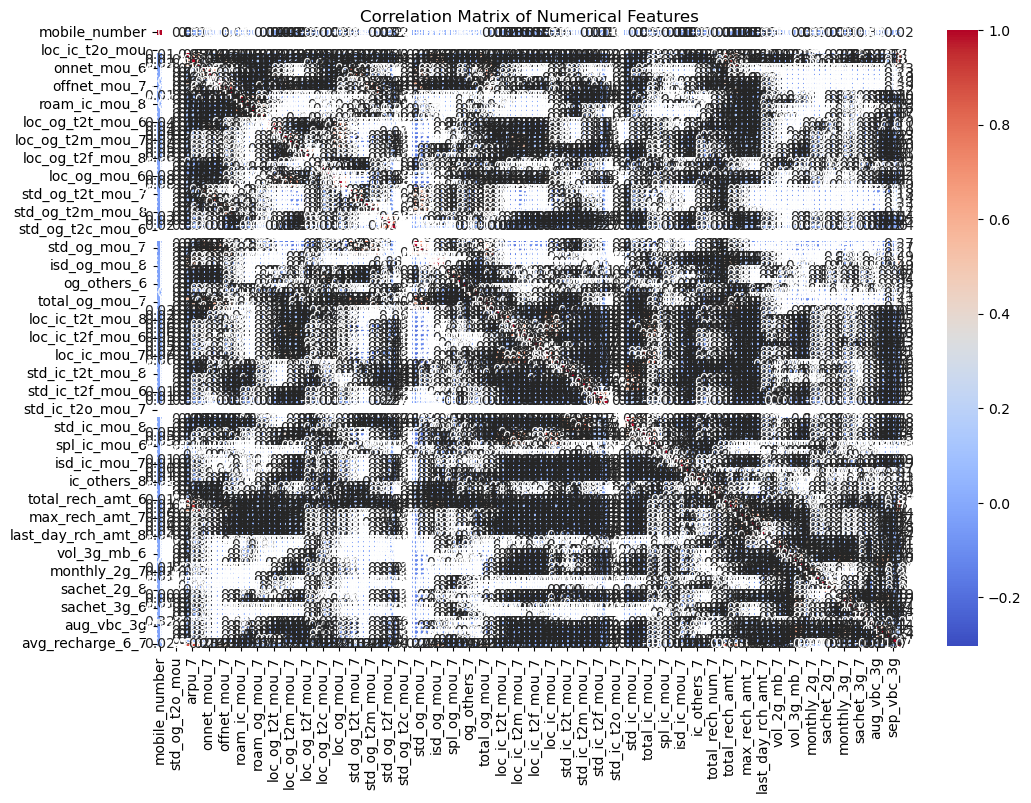

In [26]:
# Correlation matrix for numerical columns
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(high_value_df[numerical_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix of Numerical Features")
plt.show()


In [27]:
from imblearn.over_sampling import SMOTE

X = high_value_df.drop(columns=['churn'])  # Features
y = high_value_df['churn']                 # Target

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# Verify the balancing
print("Original target distribution:", y.value_counts())
print("Resampled target distribution:", y_res.value_counts())


ValueError: could not convert string to float: '6/30/2014'

In [28]:
from sklearn.model_selection import train_test_split

# Splitting the balanced data
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)


NameError: name 'X_res' is not defined

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Initialize and train the logistic regression model
baseline_model = LogisticRegression(random_state=42)
baseline_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_baseline = baseline_model.predict(X_test)

# Evaluate the baseline model
print("Accuracy:", accuracy_score(y_test, y_pred_baseline))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_baseline))
print("Classification Report:\n", classification_report(y_test, y_pred_baseline))


ValueError: could not convert string to float: '6/30/2014'

In [30]:
threshold = 0.3 * df.shape[0]
df.dropna(thresh=threshold, axis=1, inplace=True)


In [31]:
# Fill missing values for numeric columns with median
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

# Fill missing values for non-numeric columns with the mode or a placeholder (e.g., "Unknown")
non_numeric_cols = df.select_dtypes(exclude=['float64', 'int64']).columns
df[non_numeric_cols] = df[non_numeric_cols].fillna(df[non_numeric_cols].mode().iloc[0])


ValueError: Columns must be same length as key

In [32]:
print(df.columns)


Index(['mobile_number', 'circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou',
       'loc_ic_t2o_mou', 'last_date_of_month_6', 'last_date_of_month_7',
       'last_date_of_month_8', 'last_date_of_month_9', 'arpu_6',
       ...
       'sachet_3g_7', 'sachet_3g_8', 'sachet_3g_9', 'aon', 'aug_vbc_3g',
       'jul_vbc_3g', 'jun_vbc_3g', 'sep_vbc_3g', 'avg_recharge_6_7',
       'avg_recharge_6_7'],
      dtype='object', length=188)


In [33]:
df['avg_recharge_6_7'] = (df['total_rech_amt_6'] + df['total_rech_amt_7']) / 2


In [34]:
# Print all columns to identify recharge-related ones
print([col for col in df.columns if 'rech' in col.lower() or 'amt' in col.lower()])


['total_rech_num_6', 'total_rech_num_7', 'total_rech_num_8', 'total_rech_num_9', 'total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8', 'total_rech_amt_9', 'max_rech_amt_6', 'max_rech_amt_7', 'max_rech_amt_8', 'max_rech_amt_9', 'date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8', 'date_of_last_rech_9', 'last_day_rch_amt_6', 'last_day_rch_amt_7', 'last_day_rch_amt_8', 'last_day_rch_amt_9', 'avg_recharge_6_7', 'avg_recharge_6_7']


In [35]:
# Calculate average recharge for months 6 and 7
df['avg_recharge_6_7'] = (df['monthly_recharge_amt_6'] + df['monthly_recharge_amt_7']) / 2


KeyError: 'monthly_recharge_amt_6'

In [36]:
X = high_value_df.drop(columns='churn')
y = high_value_df['churn']


In [38]:
X = high_value_df.drop(columns='churn')
y = high_value_df['churn']


In [40]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)


NameError: name 'X_res' is not defined

In [41]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)


ValueError: could not convert string to float: '6/30/2014'